In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from drawinganalyses.datasets.drawings_pytorch import DrawingModule, DrawingDataset
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import random_split
import torch
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

In [27]:
import torch.nn.functional as F

In [28]:
from pathlib import Path

In [29]:
#gpu or CPU 
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device= torch.device("cpu")

In [30]:
os.chdir(os.path.expanduser("/home/jfalck/PycharmProjects/drawinganalyses"))
LOCAL_DATA_DIR = Path("/home/jfalck/PycharmProjects/drawinganalyses/drawinganalyses/data")
# Dossier de stockages des modeles
MODEL_DATA_DIR = Path("/home/jfalck/PycharmProjects/drawinganalyses/drawinganalyses/models/Humans")

annotations_file = "labels.csv" 
models_storage = MODEL_DATA_DIR
dataset_name = 'Humans'
label_to_str = {0: 'Children', 1: 'Adult'}
batch_size=4
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((256, 256))])


In [31]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [32]:
generator1 = torch.Generator().manual_seed(42)
dataset = DrawingDataset(
    dataset_name=dataset_name,
    annotations_file=annotations_file,
    data_dir=LOCAL_DATA_DIR,
    label_to_str=label_to_str,
    transform=transform)
trainset, valset, testset = random_split(dataset, [0.8, 0.1, 0.1], generator=generator1)

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=2)

dataloaders={'train':trainloader, 'val':valloader, 'test':testloader}
dataset_sizes={'train':len(trainloader)*batch_size, 'val':len(valloader)*batch_size, 'test':len(testloader)*batch_size}


In [10]:
len(testloader)

39

In [11]:
class_names = list(label_to_str.values())

In [12]:
print(class_names)

['Children', 'Adult']


/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

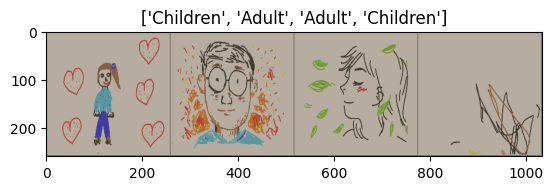

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                label = label_to_str[labels[j].item()]
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, real label : {label}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------


/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

train Loss: 0.6935 Acc: 0.7000


/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

val Loss: 0.4840 Acc: 0.8000

Epoch 1/1
----------


/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

train Loss: 0.4084 Acc: 0.8156


/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

val Loss: 0.6445 Acc: 0.7750

Training complete in 1m 23s
Best val Acc: 0.800000


In [17]:
PATH = os.path.join(MODEL_DATA_DIR, "train_Humans.pth")
torch.save(model_ft.state_dict(), PATH)

## Charger le model

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                label = label_to_str[labels[j].item()]
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, real label : {label}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
os.chdir(os.path.expanduser("/home/jfalck/PycharmProjects/drawinganalyses"))
LOCAL_DATA_DIR = Path("/home/jfalck/PycharmProjects/drawinganalyses/drawinganalyses/data")
# Dossier de stockages des modeles
MODEL_DATA_DIR = Path("/home/jfalck/PycharmProjects/drawinganalyses/drawinganalyses/models/Humans")
PATH = os.path.join(MODEL_DATA_DIR, "train_Humans.pth")
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
label_to_str = {0: 'Children', 1: 'Adult'}
class_names = list(label_to_str.values())
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
#gpu or CPU 
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device= torch.device("cpu")
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(PATH))

model_ft.eval()

/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

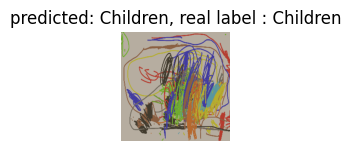

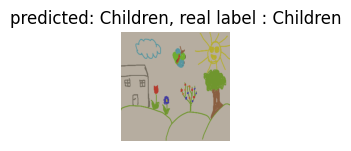

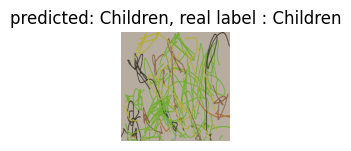

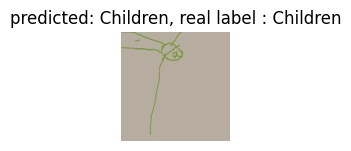

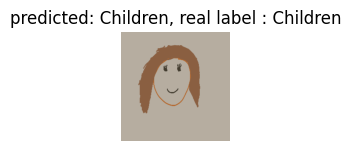

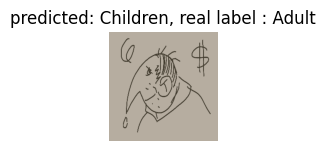

In [22]:
visualize_model(model_ft)

In [23]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
inputs, labels = next(iter(testloader))
inputs, labels = inputs.to(device), labels.to(device)
output = model_ft(inputs)
print("output=", output)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
print("class_names=",class_names)
predicted_label = class_names[(pred_label_idx.item())]
print("predicted_label=",predicted_label)
print('Predicted:', predicted_label, '(', prediction_score .squeeze().item(), ')')

/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jfalck/PycharmProjects/drawinganalyses/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc

output= tensor([[ 3.3426, -4.0407]], grad_fn=<AddmmBackward0>)
class_names= ['Children', 'Adult']
predicted_label= Children
Predicted: Children ( 0.9993788003921509 )


In [25]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from PIL import Image

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(inputs, target=pred_label_idx, n_steps=200)

In [26]:
attributions_ig

tensor([[[[ 1.9783e-03,  6.3093e-04,  1.8335e-03,  ..., -3.4125e-03,
           -2.7141e-03,  1.5402e-03],
          [ 2.5865e-03,  1.6830e-03,  7.1756e-04,  ...,  8.9547e-04,
           -2.3050e-03, -1.3934e-03],
          [-3.1457e-04,  2.8579e-03,  2.1571e-04,  ...,  9.4108e-04,
            5.4317e-04,  1.7192e-03],
          ...,
          [ 1.9429e-04,  2.1711e-04, -1.1592e-03,  ...,  1.7854e-04,
            3.7626e-04,  3.7056e-04],
          [ 7.4352e-04,  3.6535e-04, -1.0202e-03,  ...,  1.0009e-05,
            5.8405e-04,  1.0354e-03],
          [ 7.8507e-04,  1.8531e-04, -4.7659e-04,  ..., -5.7532e-05,
           -7.6140e-07,  4.3792e-05]],

         [[ 2.4186e-03,  8.6108e-04,  2.2742e-03,  ..., -4.4720e-03,
           -4.0724e-03,  9.0085e-04],
          [ 2.5164e-03,  2.2629e-03,  1.2769e-03,  ..., -8.3522e-04,
           -3.6462e-03, -2.6406e-03],
          [ 6.3673e-05,  5.1018e-03,  2.2115e-03,  ..., -6.9179e-04,
           -2.4599e-04,  1.3366e-03],
          ...,
     

In [27]:
inputs.type()

'torch.FloatTensor'

In [28]:
transposed_attr_ig = np.transpose(attributions_ig.squeeze().numpy(), (1,2,0))
transposed_image = np.transpose(inputs.squeeze().numpy(), (1,2,0))

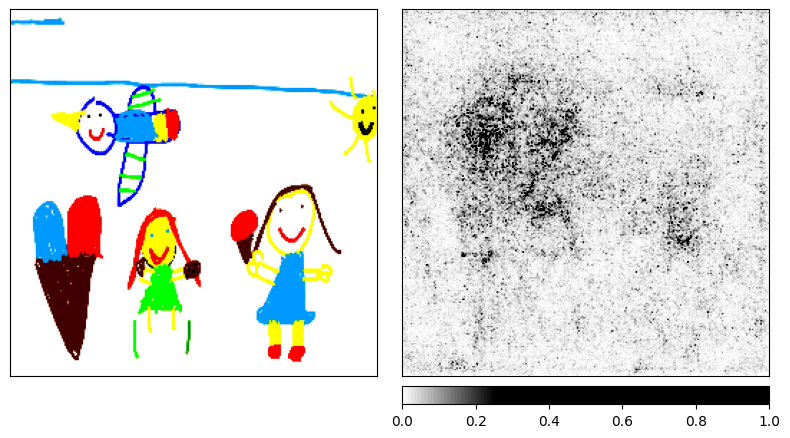

In [29]:
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(inputs,
                                            nt_type='smoothgrad_sq', target=pred_label_idx)
transposed_attr_ig_nt = np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0))
transposed_image = np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_attr_ig_nt,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [30]:
occlusion = Occlusion(model_ft)

attributions_occ = occlusion.attribute(inputs,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

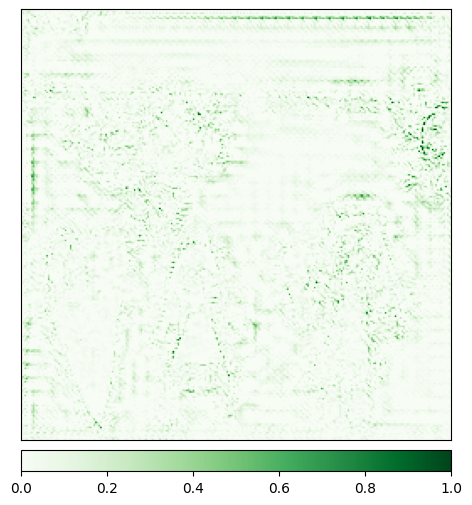

In [31]:
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

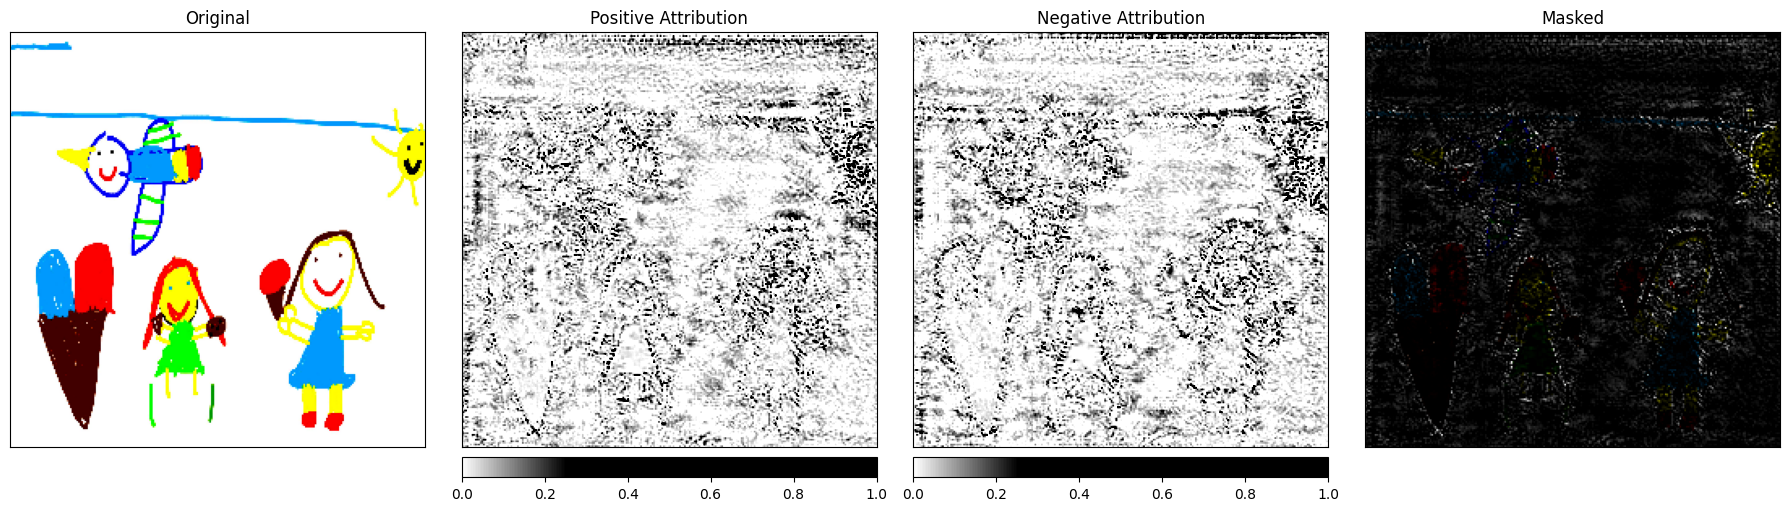

In [32]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model_ft)

# Defining baseline distribution of images
rand_img_dist = torch.cat([inputs * 0, inputs * 1])

attributions_gs = gradient_shap.attribute(inputs,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))


In [33]:
occlusion = Occlusion(model_ft)

attributions_occ = occlusion.attribute(inputs,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


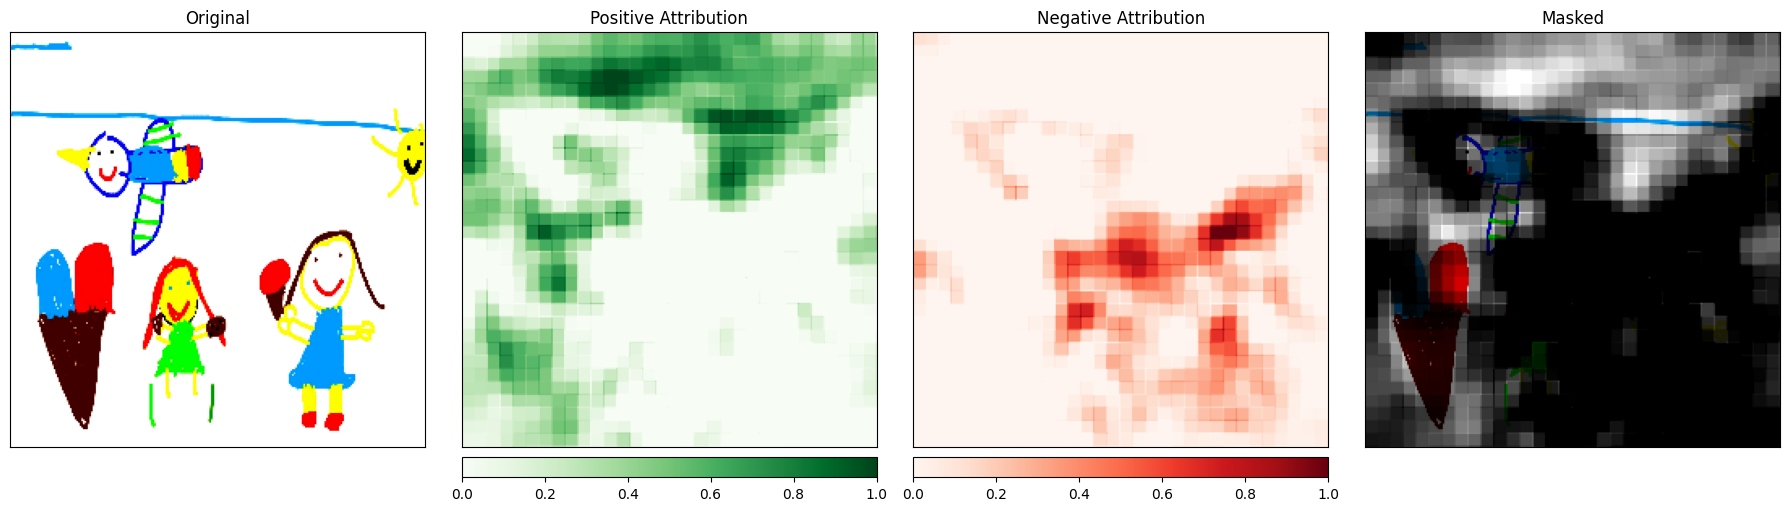

In [34]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )


## TEST DINO

In [33]:
# large model
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /home/jfalck/.cache/torch/hub/facebookresearch_dinov2_main


In [34]:
dinov2_vitl14

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [35]:
# image transformations
transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

feat_dim = 1024 # vitl14

In [25]:
print(dataset.img_labels.name[0])
print(dataset.__dict__.keys())

1
dict_values([PosixPath('/home/jfalck/PycharmProjects/drawinganalyses/drawinganalyses/data/Humans'),                          name  label
0       NOV/JOS-BLE-LIBRE.jpg      1
1       NOV/KIL-BRU-LIBRE.JPG      1
2       NOV/FLO-SIE-LIBRE.JPG      1
3    NOV/FAN-CHE-CONSIGNE.JPG      1
4       NOV/ISA-DEB-LIBRE.JPG      1
..                        ...    ...
391   MS/LOU-MUL-CONSIGNE.JPG      0
392   MS/BLA-DEA-CONSIGNE.JPG      0
393   MS/PAU-WEB-CONSIGNE.JPG      0
394      MS/ANA-GRI-LIBRE.JPG      0
395   MS/GAB-AND-CONSIGNE.JPG      0

[396 rows x 2 columns], Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
), None, {0: 'Children', 1: 'Adult'}])


In [1]:
patch_size = dinov2_vitl14.patch_size # patchsize=14
patch_h  = 520//patch_size
patch_w  = 520//patch_size
feat_dim = 1024 

folder_path = os.path.join(LOCAL_DATA_DIR,'Humans')
total_features  = []
print(dataset.label)
dataset_filter = data
with torch.no_grad():
  for img_path in tqdm(dataset.img_labels.name):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img)
    
    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

NameError: name 'dinov2_vitl14' is not defined

In [19]:


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

RuntimeError: shape '[5476, 1024]' is invalid for input of size 555134976

In [9]:
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

NameError: name 'pca_features' is not defined

In [ ]:
# segment the backgound and foreground usingthe first component
pca_features_bg = pca_features[:, 0] > 0.35 
pca_features_fg = ~pca_features_bg

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

In [ ]:
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])
    
plt.show()